<a href="https://colab.research.google.com/github/falawar7/AAI614_ELAWAR/blob/main/Week6/FE_Notebook6_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AAI614: Data Science & its Applications

*Notebook 6.6: PCA for visualization*

*Source: This notebook contains amended excerpts from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas*

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns; sns.set()

## Example I: Hand-written digits

The usefulness of the dimensionality reduction may not be entirely apparent in only two dimensions, but becomes much more clear when looking at high-dimensional data.
To see this, let's take a quick look at the application of PCA to the digits data.

We start by loading the data:

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

The data consists of 8×8 pixel images, meaning that they are 64-dimensional.
To gain some intuition into the relationships between these points, we can use PCA to project them to a more manageable number of dimensions, say two:

In [3]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


We can now plot the first two principal components of each point to learn about the data:

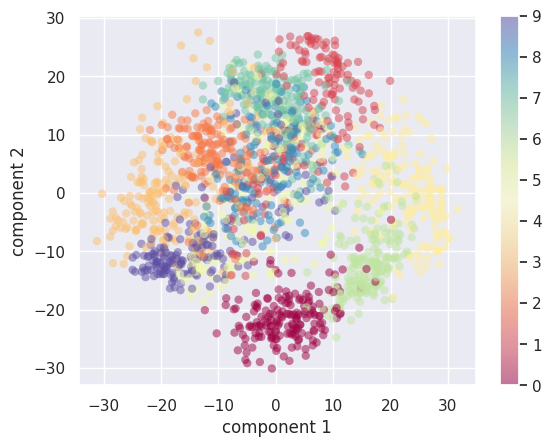

In [4]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.colormaps.get_cmap('Spectral'))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Recall what these components mean: the full data is a 64-dimensional point cloud, and these points are the projection of each data point along the directions with the largest variance.
Essentially, we have found the optimal stretch and rotation in 64-dimensional space that allows us to see the layout of the digits in two dimensions, and have done this in an unsupervised manner—that is, without reference to the labels.

### What do the components mean?

We can go a bit further here, and begin to ask what the reduced dimensions *mean*.
This meaning can be understood in terms of combinations of basis vectors.
For example, each image in the training set is defined by a collection of 64 pixel values, which we will call the vector $x$:

$$
x = [x_1, x_2, x_3 \cdots x_{64}]
$$

One way we can think about this is in terms of a pixel basis.
That is, to construct the image, we multiply each element of the vector by the pixel it describes, and then add the results together to build the image:

$$
{\rm image}(x) = x_1 \cdot{\rm (pixel~1)} + x_2 \cdot{\rm (pixel~2)} + x_3 \cdot{\rm (pixel~3)} \cdots x_{64} \cdot{\rm (pixel~64)}
$$

One way we might imagine reducing the dimension of this data is to zero out all but a few of these basis vectors.
For example, if we use only the first eight pixels, we get an eight-dimensional projection of the data, but it is not very reflective of the whole image: we've thrown out nearly 90% of the pixels!

But the pixel-wise representation is not the only choice of basis. We can also use other basis functions, which each contain some pre-defined contribution from each pixel, and write something like

$$
image(x) = {\rm mean} + x_1 \cdot{\rm (basis~1)} + x_2 \cdot{\rm (basis~2)} + x_3 \cdot{\rm (basis~3)} \cdots
$$

PCA can be thought of as a process of choosing optimal basis functions, such that adding together just the first few of them is enough to suitably reconstruct the bulk of the elements in the dataset.
The principal components, which act as the low-dimensional representation of our data, are simply the coefficients that multiply each of the elements in this series.

Unlike the pixel basis, the PCA basis allows us to recover the salient features of the input image with just a mean plus eight components!
The amount of each pixel in each component is the corollary of the orientation of the vector in our two-dimensional example.
This is the sense in which PCA provides a low-dimensional representation of the data: it discovers a set of basis functions that are more efficient than the native pixel-basis of the input data.

### Choosing the number of components

A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data.
This can be determined by looking at the cumulative *explained variance ratio* as a function of the number of components:

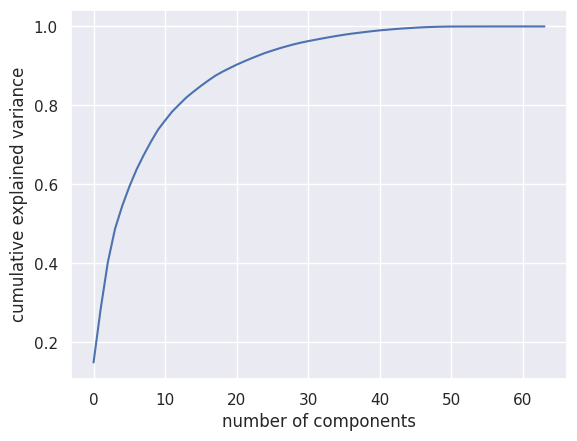

In [5]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

This curve quantifies how much of the total, 64-dimensional variance is contained within the first $N$ components.
For example, we see that with the digits the first 10 components contain approximately 75% of the variance, while you need around 50 components to describe close to 100% of the variance.

Here we see that our two-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 20 components to retain 90% of the variance.  Looking at this plot for a high-dimensional dataset can help you understand the level of redundancy present in multiple observations.

## Example II: PCA as Noise Filtering

PCA can also be used as a filtering approach for noisy data.
The idea is this: any components with variance much larger than the effect of the noise should be relatively unaffected by the noise.
So if you reconstruct the data using just the largest subset of principal components, you should be preferentially keeping the signal and throwing out the noise.

Let's see how this looks with the digits data.
First we will plot several of the input noise-free data:

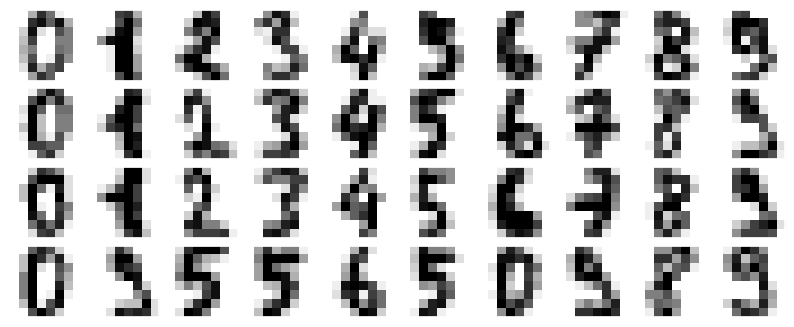

In [6]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

Now lets add some random noise to create a noisy dataset, and re-plot it:

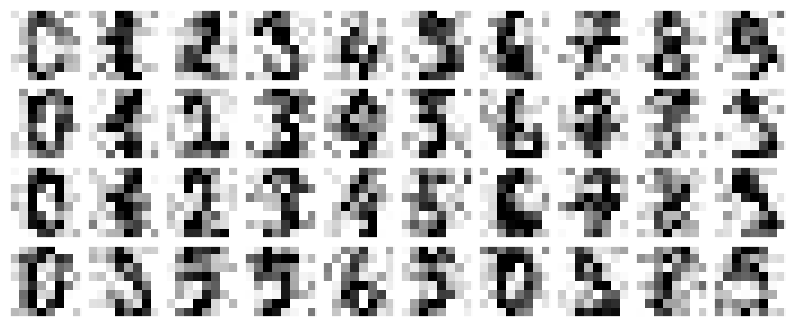

In [7]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

It's clear by eye that the images are noisy, and contain spurious pixels.
Let's train a PCA on the noisy data, requesting that the projection preserve 50% of the variance:

In [8]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

Here 50% of the variance amounts to 12 principal components.
Now we compute these components, and then use the inverse of the transform to reconstruct the filtered digits:

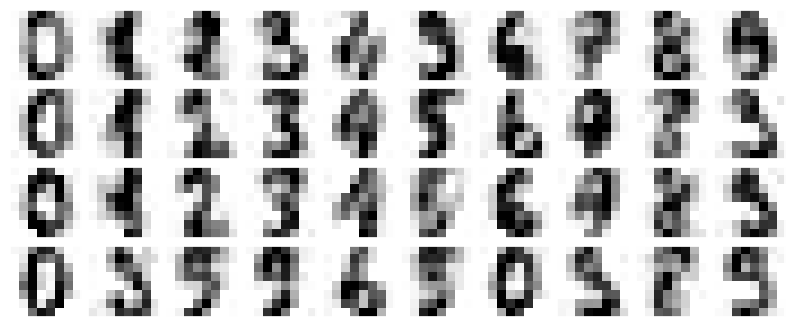

In [9]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

This signal preserving/noise filtering property makes PCA a very useful feature selection routine—for example, rather than training a classifier on very high-dimensional data, you might instead train the classifier on the lower-dimensional representation, which will automatically serve to filter out random noise in the inputs.

## Example III: Eigenfaces

Earlier we explored an example of using a PCA projection as a feature selector for facial recognition with a support vector machine.
Here we will take a look back and explore a bit more of what went into that.
Recall that we were using the Labeled Faces in the Wild dataset made available through Scikit-Learn:

In [10]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's take a look at the principal axes that span this dataset.
Because this is a large dataset, we will use ``RandomizedPCA``—it contains a randomized method to approximate the first $N$ principal components much more quickly than the standard ``PCA`` estimator, and thus is very useful for high-dimensional data (here, a dimensionality of nearly 3,000).
We will take a look at the first 150 components:

In [11]:
#from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA as RandomizedPCA
pca = RandomizedPCA(150)
pca.fit(faces.data)

PCA(n_components=150)

In this case, it can be interesting to visualize the images associated with the first several principal components (these components are technically known as "eigenvectors,"
so these types of images are often called "eigenfaces").
As you can see in this figure, they are as creepy as they sound:

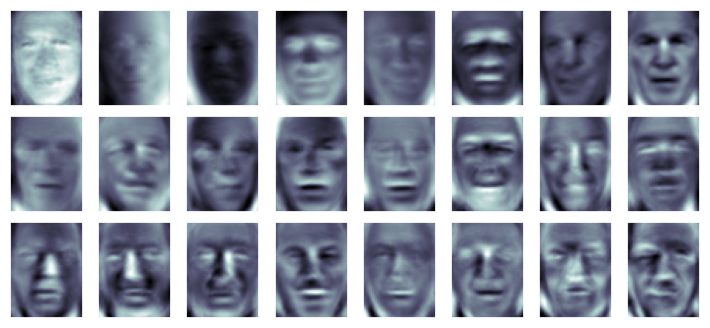

In [12]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

The results are very interesting, and give us insight into how the images vary: for example, the first few eigenfaces (from the top left) seem to be associated with the angle of lighting on the face, and later principal vectors seem to be picking out certain features, such as eyes, noses, and lips.
Let's take a look at the cumulative variance of these components to see how much of the data information the projection is preserving:

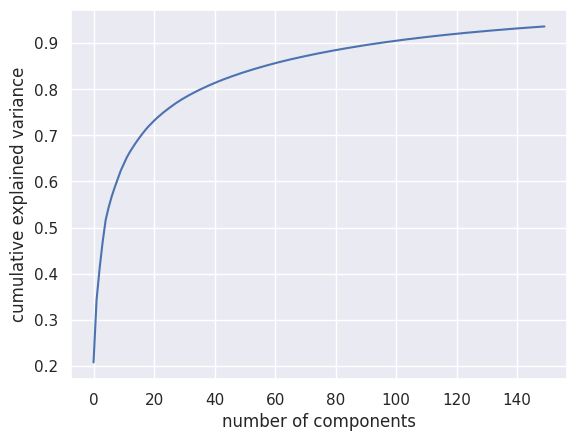

In [13]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

We see that these 150 components account for just over 90% of the variance.
That would lead us to believe that using these 150 components, we would recover most of the essential characteristics of the data.
To make this more concrete, we can compare the input images with the images reconstructed from these 150 components:

In [14]:
# Compute the components and projected faces
pca = RandomizedPCA(150).fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

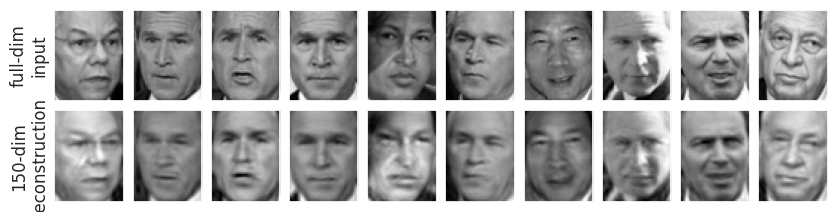

In [15]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')

ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

The top row here shows the input images, while the bottom row shows the reconstruction of the images from just 150 of the ~3,000 initial features.
This visualization makes clear why the PCA feature selection is successful: although it reduces the dimensionality of the data by nearly a factor of 20, the projected images contain enough information that we might, by eye, recognize the individuals in the image.
What this means is that our classification algorithm needs to be trained on 150-dimensional data rather than 3,000-dimensional data, which depending on the particular algorithm we choose, can lead to a much more efficient classification.